In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1 - Find Anomalies in the Data


In [114]:
df_order = pd.read_excel("data/sample.xls", sheet_name="Orders")
df_people = pd.read_excel("data/sample.xls", sheet_name="People")
df_returns = pd.read_excel("data/sample.xls", sheet_name="Returns")

Transformando em uma base de dados única


In [115]:
df_main = (
    df_order.merge(df_returns, on="Order ID", how="left")
    .merge(df_people, on="Region", how="left")
    .copy()
)

In [116]:
df_main.head().T

,0,1,2,3,4
Row ID,1,2,3,4,5
Order ID,CA-2016-152156,CA-2016-152156,CA-2016-138688,US-2015-108966,US-2015-108966
Order Date,2016-11-08 00:00:00,2016-11-08 00:00:00,2016-06-12 00:00:00,2015-10-11 00:00:00,2015-10-11 00:00:00
Ship Date,2016-11-11 00:00:00,2016-11-11 00:00:00,2016-06-16 00:00:00,2015-10-18 00:00:00,2015-10-18 00:00:00
Ship Mode,Second Class,Second Class,Second Class,Standard Class,Standard Class
Customer ID,CG-12520,CG-12520,DV-13045,SO-20335,SO-20335
Customer Name,Claire Gute,Claire Gute,Darrin Van Huff,Sean O'Donnell,Sean O'Donnell
Segment,Consumer,Consumer,Corporate,Consumer,Consumer
Country,United States,United States,United States,United States,United States
City,Henderson,Henderson,Los Angeles,Fort Lauderdale,Fort Lauderdale


In [117]:
df_main.isna().sum()

Row ID              0
Order ID            0
Order Date          0
Ship Date           0
Ship Mode           0
Customer ID         0
Customer Name       0
Segment             0
Country             0
City                0
State               0
Postal Code         0
Region              0
Product ID          0
Category            0
Sub-Category        0
Product Name        0
Sales               0
Quantity            0
Discount            0
Profit              0
Returned         9194
Person              0
dtype: int64

Vemos que o único dado com nulos é a coluna de `Returned` e trabalharemos com ela a seguir.  
Antes vamos padronizar o nome das colunas para facilitar o trabalho.


In [118]:
df_main.columns = [
    column.replace("-", "_").lower().replace(" ", "_") for column in df_main.columns
]

O dado de Returned NaN pode significar uma venda ainda nao concluida ou fracassada, sendo assim nem sucesso e nem falha, para a análise será considerado que é uma venda em "processamento".


In [119]:
df_main["returned"] = df_main["returned"].fillna(
    "Processing"
)  # Nao gosto de utilizar o 'inplace' pois é mais confuso que apenas reescrever a coluna.

### Entendendo melhor o dado

Primeiro checamos se o ID é único


In [120]:
df_main["order_id"].value_counts()

order_id
CA-2017-100111    14
CA-2017-157987    12
CA-2016-165330    11
US-2016-108504    11
CA-2015-131338    10
                  ..
CA-2016-157259     1
CA-2017-107986     1
US-2015-112508     1
US-2016-126844     1
CA-2017-119914     1
Name: count, Length: 5009, dtype: int64

In [121]:
df_main["discount_value"] = df_main["discount"] * df_main["sales"]
df_main["sales_final"] = df_main["sales"] - df_main["discount_value"]
df_main["item_value"] = df_main["sales"] / df_main["quantity"]

In [122]:
df_main[df_main["order_id"] == "CA-2017-100111"].head(3)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,product_name,sales,quantity,discount,profit,returned,person,discount_value,sales_final,item_value
6090,6091,CA-2017-100111,2017-09-20,2017-09-26,Standard Class,SV-20365,Seth Vernon,Consumer,United States,New York City,...,Hon Valutask Swivel Chairs,272.646,3,0.1,18.1764,Yes,Chuck Magee,27.2646,245.3814,90.882
6091,6092,CA-2017-100111,2017-09-20,2017-09-26,Standard Class,SV-20365,Seth Vernon,Consumer,United States,New York City,...,Logitech Wireless Boombox Speaker - portable -...,212.800,2,0.0,95.7600,Yes,Chuck Magee,0.0000,212.8000,106.400
6092,6093,CA-2017-100111,2017-09-20,2017-09-26,Standard Class,SV-20365,Seth Vernon,Consumer,United States,New York City,...,"TOPS ""Important Message"" Pads, Canary, 4-1/4 x...",38.520,9,0.0,18.1044,Yes,Chuck Magee,0.0000,38.5200,4.280


Nós temos muitos order_ids duplicados, investigando mais a fundo vendo que a tabela de pedidos a granularidade do dado é por item e não por pedido. Vamos investigar primeiro a anomalia nos pedidos de forma geral


## Vendas/Pedidos


In [123]:
def gen_sales_df(df):
    """ "
    Generate a sales dataframe grouping orders
    """
    df_sales = (
        df.groupby(
            [
                "order_id",
                "order_date",
                "ship_date",
                "ship_mode",
                "customer_id",
                "customer_name",
                "segment",
                "country",
                "city",
                "state",
                "postal_code",
                "region",
                "returned",
                "person",
            ],
            as_index=False,
        )
        .agg(
            produtcs=("product_id", "nunique"),
            total=("sales", "sum"),
            discount=("discount_value", "sum"),
            sales_liquid=("sales_final", "sum"),
            profit=("profit", "sum"),
        )
        .copy()
    )
    return df_sales

df_sales = gen_sales_df(df_main)
df_sales["discount_percentage"] = df_sales["discount"] / df_sales["total"]
df_sales["profit_negative"] = False
df_sales.loc[df_sales["profit"] < 0, "profit_negative"] = True

Vamos analisar mais de perto o Profit das vendas, em dois cenários, onde a venda foi concluida e onde ela está processando.

Analisando Returned: Processing
Total de Lucro: 391,853.12
Total de Perda: -128,688.46


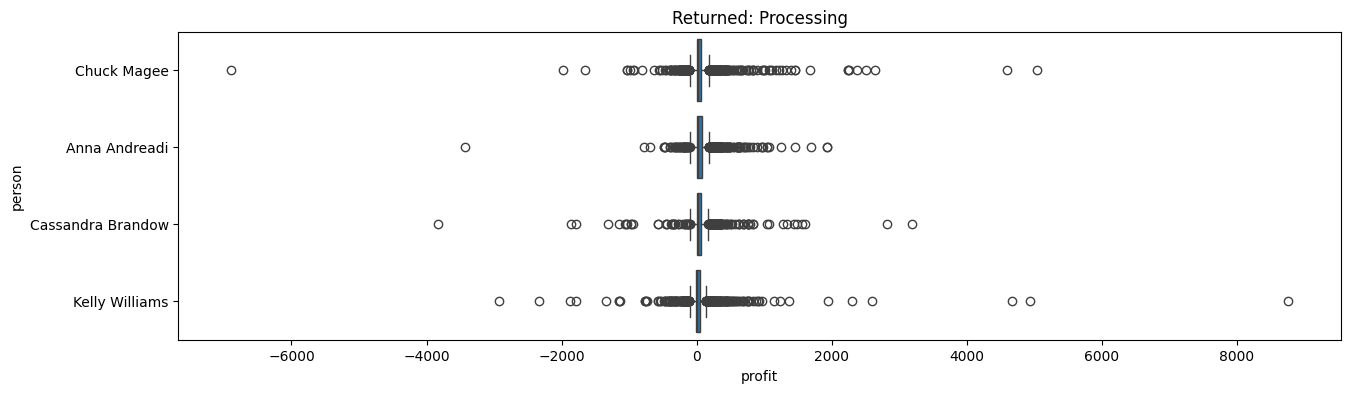

Analisando Returned: Yes
Total de Lucro: 34,477.68
Total de Perda: -11,245.32


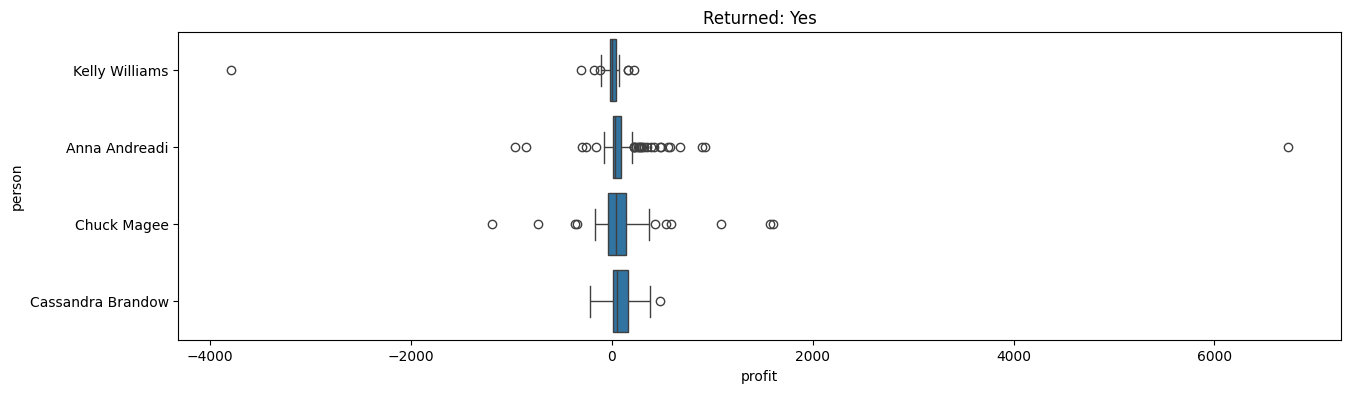

In [124]:
def profit_analysis(returned_status):
    print(f"Analisando Returned: {returned_status}")
    df_aux = df_sales[df_sales["returned"] == returned_status]
    total_profit_positiv = df_aux[df_aux["profit"] > 0]["profit"].sum()
    total_profit_negative = df_aux[df_aux["profit"] < 0]["profit"].sum()
    print(f"Total de Lucro: {total_profit_positiv:,.2f}")
    print(f"Total de Perda: {total_profit_negative:,.2f}")
    plt.figure(figsize=(15, 4))
    sns.boxplot(data=df_aux, x="profit", y="person")
    plt.title(f"Returned: {returned_status}")
    plt.show()


print(
    "Vamos analisar mais de perto o Profit das vendas, em dois cenários, onde a venda foi concluida e onde ela está processando.\n"
)
for returned_status in df_sales["returned"].unique():
    profit_analysis(returned_status)

Observando o boxplot já validando se o profit tem relação com a pessoa que vendeu, temos 2 caso de outliers que são grande anomalias quando comparados com outros, vamos verificar esses 4 pedidos a fundo.  
Primeiro vamos selecionar os dois.


In [125]:
df_outliers = pd.DataFrame()
df_sales = df_sales.sort_values("profit", ascending=False)
for returned_status in df_sales["returned"].unique():
    df_aux = df_sales[df_sales["returned"] == returned_status].copy()
    df_outliers = pd.concat([df_outliers, df_aux.head(1)])
    df_outliers = pd.concat([df_outliers, df_aux.tail(1)])

In [126]:
df_outliers[['order_id', 'returned', 'profit', 'person', 'discount']]

,order_id,returned,profit,person,discount
1992,CA-2016-118689,Processing,8762.3891,Kelly Williams,0.0000
1816,CA-2016-108196,Processing,-6892.3748,Chuck Magee,3481.5963
3596,CA-2017-140151,Yes,6734.4720,Anna Andreadi,0.0000
793,CA-2014-169019,Yes,-3791.1634,Kelly Williams,1863.1920


Observamos que os 4 outliers não possuem um padrão claro, mas os que possuem uma perda obteve um desconto de cerca de 70%.


In [127]:
df_top_outliers = df_outliers[df_outliers["profit"] > 0]
products_outliers = df_main[
    (df_main["order_id"].isin(df_top_outliers["order_id"]))
]["product_id"].unique()


In [128]:
def gen_df_item(df):
    df_item = df.groupby(["product_name", "product_id"], as_index=False).agg(
        orders=("order_id", "nunique"),
        value_std=("item_value", "std"),
        value_avg=("item_value", "mean"),
        value_max=("item_value", "max"),
        value_min=("item_value", "min"),
        discount_max=("discount", "max"),
    )
    df_item["cv"] = (
        df_item["value_std"] / df_item["value_avg"]
    ) * 100  # Calculando o coeficiente de variação
    df_item = df_item.sort_values(by="cv", ascending=False)
    return df_item
df_item = gen_df_item(df_main)
df_item[df_item["product_id"].isin(products_outliers)]

,product_name,product_id,orders,value_std,value_avg,value_max,value_min,discount_max,cv
75,"Acco Pressboard Covers with Storage Hooks, 14 ...",OFF-BI-10003712,11,1.461048,2.633545,4.91,0.982,0.8,55.478385
907,Ibico Ibimaster 300 Manual Binding System,OFF-BI-10004600,8,87.828880,308.191625,367.99,110.397,0.7,28.498140
406,Canon imageCLASS 2200 Advanced Copier,TEC-CO-10004722,5,626.097245,3079.991200,3499.99,2099.994,0.4,20.327891
72,Acco Perma 4000 Stacking Storage Drawers,OFF-ST-10001558,11,1.696213,14.763636,16.24,12.992,0.2,11.489125
1505,Stanley Bostitch Contemporary Electric Pencil ...,OFF-AR-10001958,7,1.657078,14.554286,16.98,13.584,0.2,11.385501
1725,Xerox 1898,OFF-PA-10002986,11,0.674045,6.194182,6.68,5.344,0.2,10.881911


In [129]:
df_top_outliers = df_main[
    (df_main["order_id"].isin(df_top_outliers["order_id"]))
]
df_item_outliers = df_top_outliers.merge(df_item, on="product_id", how="left")
df_item_outliers = df_item_outliers[['customer_name', 'item_value', 'value_std', 'value_max', 'profit']]
df_item_outliers['percentage_mean'] = ((df_item_outliers['value_max'] - df_item_outliers['value_std']) / df_item_outliers['value_std'])

In [130]:
df_item_outliers

,customer_name,item_value,value_std,value_max,profit,percentage_mean
0,Tamara Chand,16.24,1.696213,16.24,4.8720,8.574271
1,Tamara Chand,3499.99,626.097245,3499.99,8399.9760,4.590170
2,Tamara Chand,367.99,87.828880,367.99,331.1910,3.189852
3,Tamara Chand,4.91,1.461048,4.91,16.8413,2.360600
4,Tamara Chand,16.98,1.657078,16.98,9.5088,9.246951
5,Raymond Buch,16.24,1.696213,16.24,4.8720,8.574271
6,Raymond Buch,6.68,0.674045,6.68,9.6192,8.910312
7,Raymond Buch,3499.99,626.097245,3499.99,6719.9808,4.590170


Vemos que analisando os outliers de maior lucro, vemos que a proposta de venda os items possuem um valor até 9 vezes maior do que ele é vendido realmenteem média.

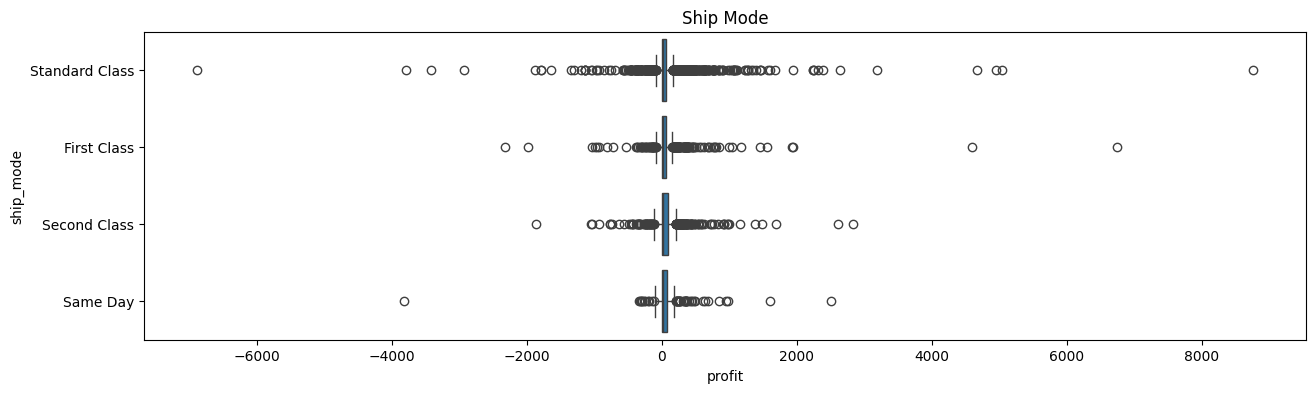

In [131]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df_sales, x="profit", y="ship_mode")
plt.title(f"Ship Mode")
plt.show()

Vemos que para alguns modos de entrega a variação de lucro é maior que em outros modos.

Verificando a grande quantidade de vendas com prejuízo, vamos analisa-las a fundo.

In [132]:
df_true_sales = df_sales[df_sales["returned"] == "Yes"].copy()
df_ts_neg = df_true_sales[df_true_sales["profit"] < 0].copy()

In [133]:
df_ts_neg.sort_values(by="discount_percentage", ascending=False).head(10)

,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,...,region,returned,person,produtcs,total,discount,sales_liquid,profit,discount_percentage,profit_negative
793,CA-2014-169019,2014-07-26,2014-07-30,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,...,Central,Yes,Kelly Williams,6,2656.716,1863.1920,793.5240,-3791.1634,0.701314,True
4203,US-2014-105137,2014-10-10,2014-10-10,Same Day,RB-19435,Richard Bierner,Consumer,United States,Columbus,Ohio,...,East,Yes,Chuck Magee,2,120.258,84.1806,36.0774,-84.7894,0.700000,True
2619,CA-2016-159023,2016-11-03,2016-11-05,First Class,NW-18400,Natalie Webber,Consumer,United States,Portland,Oregon,...,West,Yes,Anna Andreadi,2,184.149,128.9043,55.2447,-255.4524,0.700000,True
4678,US-2016-157490,2016-10-06,2016-10-07,First Class,LB-16795,Laurel Beltran,Home Office,United States,Pueblo,Colorado,...,West,Yes,Anna Andreadi,4,801.550,527.1050,274.4450,-961.5321,0.657607,True
1416,CA-2015-146262,2015-01-02,2015-01-09,Standard Class,VW-21775,Victoria Wilson,Corporate,United States,Medina,Ohio,...,East,Yes,Chuck Magee,5,1816.696,1105.6706,711.0254,-1196.0596,0.608616,True
4029,CA-2017-161557,2017-09-03,2017-09-08,Standard Class,AG-10900,Arthur Gainer,Consumer,United States,Dallas,Texas,...,Central,Yes,Kelly Williams,1,108.400,65.0400,43.3600,-105.6900,0.600000,True
1691,CA-2015-169397,2015-12-24,2015-12-27,First Class,JB-15925,Joni Blumstein,Consumer,United States,Dublin,Ohio,...,East,Yes,Chuck Magee,6,627.924,375.4668,252.4572,-365.9870,0.597949,True
3651,CA-2017-142867,2017-03-17,2017-03-21,Standard Class,PO-19180,Philisse Overcash,Home Office,United States,Houston,Texas,...,Central,Yes,Kelly Williams,2,24.048,13.0752,10.9728,-18.8316,0.543713,True
3487,CA-2017-134194,2017-12-25,2018-01-01,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Dallas,Texas,...,Central,Yes,Kelly Williams,5,160.162,82.2704,77.8916,-122.6016,0.513670,True
419,CA-2014-133690,2014-08-03,2014-08-05,First Class,BS-11755,Bruce Stewart,Consumer,United States,Denver,Colorado,...,West,Yes,Anna Andreadi,2,221.350,109.8950,111.4550,-161.5825,0.496476,True


Cerca de 9 vendas com mais de 50% de desconto dos valores.


## Clientes

Analisando mais proximamente os dados de clientes.


In [134]:
df_customers = (
    df_true_sales.groupby("customer_name", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        orders_negative=("profit_negative", "sum"),
        city=("city", "nunique"),
        total=("total", "sum"),
        discount=("discount", "sum"),
        sales_liquid=("sales_liquid", "sum"),
        profit=("profit", "sum"),
    )
    .sort_values(by="orders", ascending=False)
)

In [135]:
total_customer = df_customers.shape[0]
customer_diferent_city = df_customers[df_customers["city"] > 1].shape[0]
customer_same_city = df_customers[df_customers["city"] == 1].shape[0]

print(
    f"Quantidade de clientes que compraram em mais de uma cidade: {customer_diferent_city/total_customer:.2%}"
)

Quantidade de clientes que compraram em mais de uma cidade: 15.79%


Há uma grande quantidade de clientes que fazem pedidos em cidades distintas


In [136]:
df_customers["percentage_negative_orders"] = (
    df_customers["orders_negative"] / df_customers["orders"]
)
negative_orders_customers = df_customers[
    df_customers["percentage_negative_orders"] >= 0.5
].shape[0]

print(
    f"Cerca de {negative_orders_customers/total_customer:.2%} dos clientes tiveram mais de 50% de pedidos com prejuizo"
)

Cerca de 19.43% dos clientes tiveram mais de 50% de pedidos com prejuizo


## Itens

Analisando os itens vendidos


In [137]:
df_main["profit_negative"] = False
df_main.loc[df_main["profit"] < 0, "profit_negative"] = True
df_main_true = df_main[df_main["returned"] == "Yes"].copy()

In [138]:
df_products = df_main_true.groupby("product_name", as_index=False).agg(
    orders=("order_id", "nunique"), profit_negative=("profit_negative", "sum")
)
df_products["negative_profit_percentage"] = (
    df_products["profit_negative"] / df_products["orders"]
)

In [139]:
neg_prof = df_products[df_products["negative_profit_percentage"] > 0.5].shape[0]
produtc = df_products.shape[0]
print(
    f"Perto de {neg_prof/produtc:.2%} dos produtos vendidos tiveram mais de 50% dos pedidos vendidos com prejuizo"
)

Perto de 14.86% dos produtos vendidos tiveram mais de 50% dos pedidos vendidos com prejuizo


In [140]:

df_item = gen_df_item(df_main)

Alguns produtos o preço pode variar cerca de 90% entre as vendas. Como por exemplo o produto `OFF-AP-10004655` e `OFF-AP-10004136`


In [141]:
print("Exemplo de produto com maior coeficiente de variação")
df_main[df_main["product_id"] == "OFF-AP-10004655"]

Exemplo de produto com maior coeficiente de variação


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,sales,quantity,discount,profit,returned,person,discount_value,sales_final,item_value,profit_negative
4100,4101,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,2.264,1,0.8,-5.2072,Processing,Kelly Williams,1.8112,0.4528,2.264,True
9329,9330,CA-2015-164497,2015-11-28,2015-11-30,First Class,AJ-10945,Ashley Jarboe,Consumer,United States,San Francisco,...,45.280,4,0.0,15.3952,Processing,Anna Andreadi,0.0000,45.2800,11.320,False


Aparentemente alguns produtos são utilizados como "brinde", pois eles apresentam um desconto considerável em específicos cenários quando comprados junt a outros produtos.


In [142]:
print("Exemplo de venda que produtos acompanhados de menor valor tem maior desconto.")
df_main[df_main["order_id"] == "US-2017-102288"]

Exemplo de venda que produtos acompanhados de menor valor tem maior desconto.


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,sales,quantity,discount,profit,returned,person,discount_value,sales_final,item_value,profit_negative
4100,4101,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,2.264,1,0.8,-5.2072,Processing,Kelly Williams,1.8112,0.4528,2.264,True
4101,4102,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,0.444,1,0.8,-1.1100,Processing,Kelly Williams,0.3552,0.0888,0.444,True
4102,4103,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,146.176,8,0.2,47.5072,Processing,Kelly Williams,29.2352,116.9408,18.272,False


# Conclusão

- Há muitas vendas com prejuízo, incluindo vendas que ainda não foram concluídas.
- Há muitos clientes que fazem pedidos em cidades distintas, então é interessante verificar o contexto sobre as vendas, talvez seja da natureza do produto ou dos clientes, ou é um erro de cadastro.
- Há muitos produtos que variam muito de preço, importante verificar o motivo de terem descontos de mais de 70%, se é uma estratégia de venda ou um erro.
- No cenário atual a empresa não terá prejuizo se todas as vendas forem concluídas, porém se apenas vendas que não gerem lucro consigam ser fechada haverá um prejuízo.
- Importante haver um padrão nos valores, verificando o boxplot das vendas não concluidas, notamos que o profit é muito variável com vários outliers.